In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

import xml.etree.ElementTree as ET
import cv2

import tensorflow as tf
from tensorflow.keras.layers   import Input, Dense, Flatten
from tensorflow.keras.layers   import Conv2D, BatchNormalization,MaxPool2D, Dropout, MaxPooling2D
from tensorflow.keras.layers   import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16

In [7]:
def getBB(file_path):
  try:
    tree = ET.parse(file_path)
  except FileNotFoundError:
    return None  
  root = tree.getroot()  
  ob = root.find('object')
  bndbox = ob.find('bndbox')
  xmin = bndbox.find('xmin').text
  xmax = bndbox.find('xmax').text
  ymin = bndbox.find('ymin').text
  ymax = bndbox.find('ymax').text
  return [int(xmin), int(ymin), int(xmax), int(ymax)]

In [4]:
def load_car(target_size= (224, 224)):
    input_file = "/content/gdrive/MyDrive/annotations/list.txt"
    file = open(input_file)
    list_txt = file.readlines()
    file.close()
    
    list_txt = list_txt[1:]
    np.random.shuffle(list_txt)

    train_dataset= {"name": [], "label": [], "image": [ ], "box": [] }
    test_dataset = {"name": [], "label": [], "image": [ ]}

    for line in list_txt:    
        image_name, class_id, species, breed_id = line.split()
        image_file= "/content/gdrive/MyDrive/images/"+ image_name + ".jpg"
        box_file  = "/content/gdrive/MyDrive/annotations/xmls/"+ image_name + ".xml"     

        if not os.path.exists(image_file):
            continue

        img = image.load_img(image_file)
        sx = target_size[0]/img.width
        sy = target_size[1]/img.height
            
        img = img.resize(size=target_size)
        img = image.img_to_array(img)
          
        if  os.path.exists(box_file):
            box = getBB(box_file)
            box[0] = round(box[0]*sx)
            box[1] = round(box[1]*sy)
            box[2] = round(box[2]*sx)
            box[3] = round(box[3]*sy)
            train_dataset["box"].append(box)
            train_dataset["name"].append(image_name)
            train_dataset["label"].append(int(species)-1)
            train_dataset["image"].append(img)          
            
        else:
            test_dataset["name"].append(image_name)
            test_dataset["label"].append(int(species)-1)
            test_dataset["image"].append(img)        

    train_dataset["image"] = np.array(train_dataset["image"])
    train_dataset["box"]  = np.array(train_dataset["box"])
    train_dataset["label"] = np.array(train_dataset["label"]) - 1 
    train_dataset["name"]  = np.array(train_dataset["name"])

    test_dataset["image"] = np.array(test_dataset["image"])
    test_dataset["label"] = np.array(test_dataset["label"]) - 1
    test_dataset["name"]  = np.array(test_dataset["name"])    
    return train_dataset, test_dataset

In [12]:
train_dataset, test_dataset = load_car()
print("train_dataset['image'].shape=", train_dataset['image'].shape)
print("test_dataset['image'].shape=", test_dataset['image'].shape)
x_train = train_dataset["image"]/255.0
x_test  = test_dataset["image"]/255.0



train_dataset['image'].shape= (884, 224, 224, 3)
test_dataset['image'].shape= (16, 224, 224, 3)


In [67]:
def make_labels_car(dataset, train_data=True):

    label = dataset["label"]
    N = dataset['image'].shape[0]
    
    if train_data:  
        size = dataset['image'].shape[1]
        box   = dataset["box"]

        x = (box[:,0] + box[:,2])/(2.*size)
        y = (box[:,1] + box[:,3])/(2.*size)
        w = (box[:,2] - box[:,0])/size
        h = (box[:,3] - box[:,1])/size
    else:             
        x = np.full(shape = (N,), fill_value=0.5, dtype="float32")
        y = np.full(shape = (N,), fill_value=0.5, dtype="float32")
        w = np.ones(shape = (N,), dtype="float32")
        h = np.ones(shape = (N,), dtype="float32")                

    pc = np.ones(shape = (N,), dtype="float32")
        
    C = np.zeros((N, 2))
    C[np.arange(N), label]= 1

    label_y = np.zeros(shape=(N, 7), dtype="float32")      
    label_y[:, 0] = pc
    label_y[:, 1] = x
    label_y[:, 2] = y
    label_y[:, 3] = w
    label_y[:, 4] = h
    label_y[:, 5:]= C        
    return label_y
       
y_train = make_labels_car(train_dataset)
y_test  = make_labels_car(test_dataset, train_data=False)

In [68]:
def IOU(y_true, y_pred):

    b1_pc, b1_x, b1_y, b1_w, b1_h, b1_c1, b1_c2 = tf.unstack(y_true, 7, axis=-1)
    b2_pc, b2_x, b2_y, b2_w, b2_h, b2_c1, b2_c2 = tf.unstack(y_pred, 7, axis=-1)
   
    zero = tf.convert_to_tensor(0.0, y_true.dtype) # zero = 0.0   
    b1_width  = tf.maximum(zero, b1_w)
    b1_height = tf.maximum(zero, b1_h)
    b2_width  = tf.maximum(zero, b2_w)
    b2_height = tf.maximum(zero, b2_h)

    b1_w2 = b1_width/2
    b1_h2 = b1_height/2
    b1_xmin = b1_x - b1_w2
    b1_ymin = b1_y - b1_h2
    b1_xmax = b1_x + b1_w2
    b1_ymax = b1_y + b1_h2
    
    b2_w2 = b2_width/2
    b2_h2 = b2_height/2
    b2_xmin = b2_x - b2_w2
    b2_ymin = b2_y - b2_h2
    b2_xmax = b2_x + b2_w2
    b2_ymax = b2_y + b2_h2
    
    b1_width  = tf.maximum(zero, b1_xmax - b1_xmin)
    b1_height = tf.maximum(zero, b1_ymax - b1_ymin)
    b2_width  = tf.maximum(zero, b2_xmax - b2_xmin)
    b2_height = tf.maximum(zero, b2_ymax - b2_ymin)
    b1_area = b1_width * b1_height
    b2_area = b2_width * b2_height
    
    intersect_ymin = tf.maximum(b1_ymin, b2_ymin)
    intersect_xmin = tf.maximum(b1_xmin, b2_xmin)
    intersect_ymax = tf.minimum(b1_ymax, b2_ymax)
    intersect_xmax = tf.minimum(b1_xmax, b2_xmax)
    
    intersect_width = tf.maximum(zero, intersect_xmax - intersect_xmin)
    intersect_height = tf.maximum(zero, intersect_ymax - intersect_ymin)
    intersect_area = intersect_width * intersect_height

    union_area = b1_area + b2_area - intersect_area
    iou = intersect_area/union_area
    return iou

In [3]:
def custom_loss(y_true, y_pred):
    y_true_conf, b1_x, b1_y, b1_w, b1_h, b1_c1, b1_c2 = tf.unstack(y_true, 7, axis=-1)
    y_pred_conf, b2_x, b2_y, b2_w, b2_h, b2_c1, b2_c2 = tf.unstack(y_pred, 7, axis=-1)
  
    iou = IOU(y_true, y_pred)
    loss_conf = tf.square(y_true_conf*iou- y_pred_conf)

    loss_xy = tf.square(b1_x - b2_x) + tf.square(b1_y - b2_y)    

    b1_w = tf.sqrt(b1_w)
    b1_h = tf.sqrt(b1_h)  
    b2_w = tf.sqrt(b2_w)
    b2_h = tf.sqrt(b2_h)  
    loss_wh = tf.square(b1_w -b2_w) + tf.square(b1_h - b2_h)
    
    epsilon=1e-12
    b2_c1 = tf.keras.backend.clip(b2_c1, epsilon, 1.0-epsilon)
    b2_c2 = tf.keras.backend.clip(b2_c2, epsilon, 1.0-epsilon)           
    loss_class = -(b1_c1*tf.math.log(b2_c1) + b1_c2*tf.math.log(b2_c2))
    
    loss = loss_conf + (loss_xy+ loss_wh + loss_class)*y_true_conf
    
    loss = tf.reduce_mean(loss, axis=-1)       
    return loss

In [2]:
def custom_acc(y_true, y_pred):
    y_true_class = y_true[...,-2:]
    y_pred_class = y_pred[...,-2:]
    return tf.keras.metrics.categorical_accuracy(y_true_class, y_pred_class) 

In [1]:
def custom_activations(x):
    x_0 = tf.keras.activations.sigmoid(x[...,:5])
    x_1 = tf.keras.activations.softmax(x[...,5:])
    new_x = tf.keras.layers.concatenate([x_0, x_1], axis = -1)
    return new_x

In [72]:
def create_VGG(input_shape=(224, 224, 3), num_outs = 7):

    inputs = Input(shape = input_shape)
    vgg_model = VGG16(weights = 'imagenet', include_top = False, input_tensor = inputs)
    vgg_model.trainable = False # freeze

    x = vgg_model.output
    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dense(32)(x)
    x = LeakyReLU()(x)

    outs  = Dense(num_outs, activation =custom_activations)(x)
    model = tf.keras.Model(inputs = inputs, outputs = outs)
    return model

model= create_VGG()

In [77]:
opt = RMSprop(learning_rate = 0.001)
model.compile(optimizer = opt, loss = custom_loss, metrics =  [IOU, custom_acc])
ret = model.fit(x_train, y_train, epochs =400, batch_size =8, verbose = 2)
model.evaluate(x_train, y_train, verbose = 2)
model.evaluate(x_test,  y_test, verbose = 2)

Epoch 1/400
111/111 - 6s - loss: 0.0197 - IOU: 0.7647 - custom_acc: 1.0000
Epoch 2/400
111/111 - 6s - loss: 0.0212 - IOU: 0.7513 - custom_acc: 1.0000
Epoch 3/400
111/111 - 6s - loss: 0.0197 - IOU: 0.7590 - custom_acc: 1.0000
Epoch 4/400
111/111 - 6s - loss: 0.0174 - IOU: 0.7641 - custom_acc: 1.0000
Epoch 5/400
111/111 - 6s - loss: 0.0181 - IOU: 0.7668 - custom_acc: 1.0000
Epoch 6/400
111/111 - 5s - loss: 0.0183 - IOU: 0.7678 - custom_acc: 1.0000
Epoch 7/400
111/111 - 5s - loss: 0.0172 - IOU: 0.7734 - custom_acc: 1.0000
Epoch 8/400
111/111 - 5s - loss: 0.0164 - IOU: 0.7746 - custom_acc: 1.0000
Epoch 9/400
111/111 - 5s - loss: 0.0158 - IOU: 0.7749 - custom_acc: 1.0000
Epoch 10/400
111/111 - 5s - loss: 0.0157 - IOU: 0.7765 - custom_acc: 1.0000
Epoch 11/400
111/111 - 5s - loss: 0.0155 - IOU: 0.7782 - custom_acc: 1.0000
Epoch 12/400
111/111 - 5s - loss: 0.0142 - IOU: 0.7861 - custom_acc: 1.0000
Epoch 13/400
111/111 - 5s - loss: 0.0152 - IOU: 0.7847 - custom_acc: 1.0000
Epoch 14/400
111/111 

[0.2147045135498047, 0.4322938323020935, 1.0]

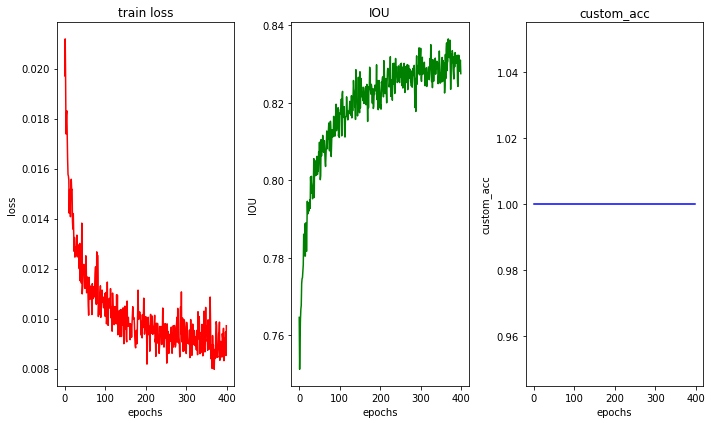

In [78]:
fig, ax = plt.subplots(1, 3, figsize = (10, 6))
ax[0].plot(ret.history['loss'], "r-")
ax[0].set_title('train loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['IOU'], "g-")
ax[1].set_title('IOU')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('IOU')

ax[2].plot(ret.history['custom_acc'], "b-")
ax[2].set_title('custom_acc')
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('custom_acc')
fig.tight_layout()
plt.show()

k = 16
train_pred = model.predict(x_train[:k])
test_pred  = model.predict(x_test[:k])

true_label = train_dataset["label"][:k]
pred_label = np.argmax(train_pred[:, -2:], axis=-1)
train_matches = np.sum(true_label== pred_label)

true_label = test_dataset["label"][:k]
pred_label = np.argmax(test_pred[:, -2:], axis=-1)
test_matches = np.sum(true_label== pred_label)

class_name=['Car']

In [79]:
def create_label(pred): 
    p = pred[:, -2:]
    p = tf.argmax(p, axis=-1)
    return p.numpy()


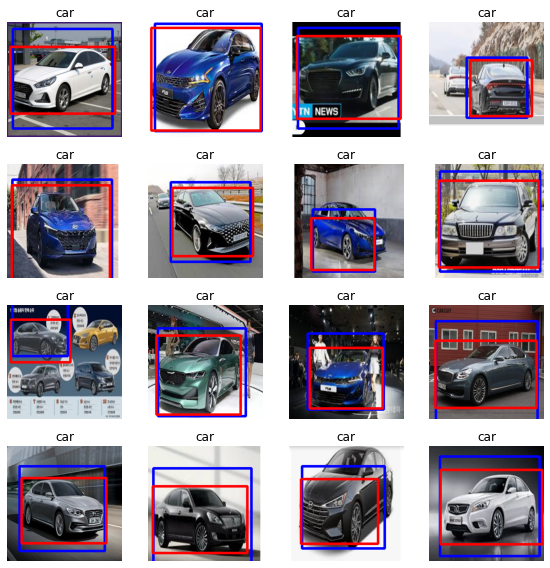

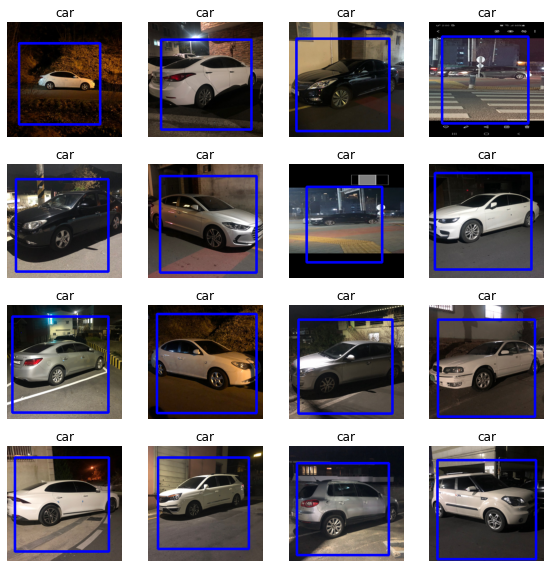

In [80]:
def display_images(img, pred, true_box=None, size= 224):

    box  = pred[:, 1:5]*size 

    label = create_label(pred)

    k =  pred.shape[0] 
    fig = plt.figure(figsize=(8, k//2))
   
    for i in range(k):
        plt.subplot(k//4, 4, i+1)
        plt.title('car')

        a_img = (img[i]*255).astype('uint8')

        x, y, w, h = box[i]
        w2 = w/2
        h2 = h/2
        xmin = int(x - w2)
        xmax = int(x + w2)
        ymin = int(y - w2)
        ymax = int(y + w2)                                
        cv2.rectangle(a_img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 3)

        if true_box is not None:
            xmin, ymin, xmax, ymax = true_box[i]
            cv2.rectangle(a_img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
            
        plt.imshow(a_img)
        plt.axis("off")
    fig.tight_layout()
    plt.show()

display_images(x_train[:k], train_pred, train_dataset["box"][:k])
display_images(x_test[:k],  test_pred)